Data loaded successfully from 'line_detection_features.csv'.
Shape of data: (1151, 28)

First 5 rows of data:
       filename  mask_centroid_x_norm  mask_centroid_y_norm  mask_hu_moment_1  \
0  00420478.png              0.493578              0.039989          7.549179   
1  00420523.png              0.486263              0.044861          4.567633   
2  00420564.png              0.304329              0.036196          8.142678   
3  00420604.png              0.302199              0.032670          7.783701   
4  00420644.png              0.338356              0.034064          5.305382   

   mask_hu_moment_2  mask_hu_moment_3  mask_hu_moment_4  mask_hu_moment_5  \
0         56.550603          0.885567          0.125388         -0.003102   
1         20.625153          0.902070          0.634771          0.479683   
2         66.113061         42.167638         42.773745       1816.582012   
3         60.426510         74.225608         74.941466       5589.332635   
4         28.07105

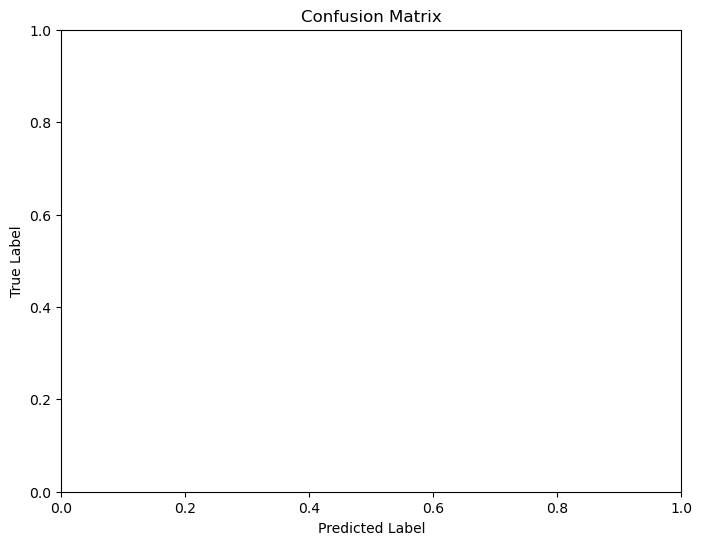


--- SVM Training Script Finished ---
Next Steps:
1. Review the Accuracy, Classification Report, and Confusion Matrix.
2. If performance is not satisfactory, consider Hyperparameter Tuning (e.g., using GridSearchCV).
3. Add more diverse training data if necessary, especially for misclassified cases.
4. Experiment with different SVM kernels (e.g., 'linear', 'poly') and their parameters.
5. Implement Cross-Validation for a more robust performance estimate.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
input_csv_path = "line_detection_features.csv" # Path to your generated CSV file

# --- 1. Load Data ---
try:
    df = pd.read_csv(input_csv_path)
    print(f"Data loaded successfully from '{input_csv_path}'.")
    print(f"Shape of data: {df.shape}")
    print("\nFirst 5 rows of data:")
    print(df.head())
    print("\nLabel distribution:")
    print(df['line_label'].value_counts())

except FileNotFoundError:
    print(f"Error: The file '{input_csv_path}' was not found. Please ensure the CSV is in the same directory as the script, or provide the full path.")
    exit()

# --- 2. Define Features (X) and Labels (y) ---
# 'filename' is just for identification, not a feature.
# 'line_label' is our target variable (y).
# 'cx' is a strong indicator of position, so it's a valuable feature.
# Drop the 'filename' column for features.
X = df.drop(['filename', 'line_label'], axis=1)
y = df['line_label']

# --- 3. Handle Potential Missing or Infinite Values ---
# While the feature extraction script tried to prevent NaNs, it's good practice to check.
if X.isnull().sum().sum() > 0:
    print("\nWarning: NaN values found in features. Filling with 0.")
    X = X.fillna(0) # Or X.fillna(X.mean()) - depending on context
if np.isinf(X).sum().sum() > 0:
    print("\nWarning: Infinite values found in features. Replacing with large finite number.")
    X = X.replace([np.inf, -np.inf], 1e10) # Replace with a large number or 0

# --- 4. Data Scaling ---
# SVMs are sensitive to feature scaling. Standardize features to have zero mean and unit variance.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("\nFeatures scaled successfully.")

# Convert scaled features back to DataFrame for better readability (optional, but good for inspection)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
print("\nFirst 5 rows of scaled data:")
print(X_scaled_df.head())


# --- 5. Split Data into Training and Testing Sets ---
# We'll use 80% for training and 20% for testing. stratify=y ensures
# that the proportion of labels is the same in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# --- 6. Initialize and Train SVM Model ---
# Using a Support Vector Classifier (SVC) with a Radial Basis Function (RBF) kernel.
# C: Regularization parameter. Smaller C means stronger regularization.
# gamma: Kernel coefficient. 'scale' (default) uses 1 / (n_features * X.var()).
print("\nTraining SVM model...")
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)
print("SVM model training complete.")

# --- 7. Evaluate the Model ---
print("\nEvaluating model performance...")
y_pred = svm_model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# Classification Report (Precision, Recall, F1-score for each class)
# Labels: -1 (Left), 0 (Center), 1 (Right), 2 (No Line Detected)
target_names = ['Left (-1)', 'Center (0)', 'Right (1)', 'No Line (2)']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optional: Visualize Confusion Matrix
plt.figure(figsize=(8, 6))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\n--- SVM Training Script Finished ---")
print("Next Steps:")
print("1. Review the Accuracy, Classification Report, and Confusion Matrix.")
print("2. If performance is not satisfactory, consider Hyperparameter Tuning (e.g., using GridSearchCV).")
print("3. Add more diverse training data if necessary, especially for misclassified cases.")
print("4. Experiment with different SVM kernels (e.g., 'linear', 'poly') and their parameters.")
print("5. Implement Cross-Validation for a more robust performance estimate.")

In [ ]:
# Assuming svm_model, X_train, y_train, X_test, y_test are already defined from the previous script

# Calculate training accuracy
train_accuracy = svm_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Calculate validation (test) accuracy
val_accuracy = svm_model.score(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.4f}")


Training Accuracy: 0.9533
Validation Accuracy: 0.9307


In [5]:
import joblib
import os

# --- Configuration for saving ---
model_filename = "svm_line_classifier.joblib"
scaler_filename = "scaler_line_features.joblib"

# --- Save the trained SVM model ---
try:
    joblib.dump(svm_model, model_filename)
    print(f"SVM model successfully packaged and saved as '{model_filename}'")
except Exception as e:
    print(f"Error saving SVM model: {e}")

# --- Save the StandardScaler ---
try:
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler successfully packaged and saved as '{scaler_filename}'")
except Exception as e:
    print(f"Error saving scaler: {e}")

print("\nTo load these later, you would use:")
print(f"loaded_model = joblib.load('{model_filename}')")
print(f"loaded_scaler = joblib.load('{scaler_filename}')")

SVM model successfully packaged and saved as 'svm_line_classifier.joblib'
Scaler successfully packaged and saved as 'scaler_line_features.joblib'

To load these later, you would use:
loaded_model = joblib.load('svm_line_classifier.joblib')
loaded_scaler = joblib.load('scaler_line_features.joblib')
